This is a summary of other notebooks, I realized I need to write a summary incase I forgot everything...

In [48]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from nbodykit.lab import *
import bigfile
import numpy as np
import sys
import glob

### 3 kinds of pwoer spectrums
first, we have 3 kinds of power spectrum in nbodykit:
linear,
halofit,
Zel'dovich

this is how they look like in k space

Text(0.5,1,'matter power spectrum')

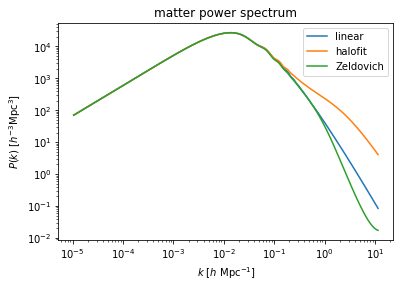

In [108]:
h=0.7
omega_b=0.044
omega_m=0.25
ns=0.95
sigma8=0.8
redshift=0.3



cosmo = cosmology.cosmology.Cosmology(h=h,Omega0_b=omega_b,Omega0_cdm=omega_m-omega_b,n_s=ns)
cosmo2=cosmo.match(sigma8=sigma8)
Plin = cosmology.LinearPower(cosmo2, redshift)
Plin2 = cosmology.HalofitPower(cosmo2, redshift)
Plin3 = cosmology.ZeldovichPower(cosmo2, redshift)
logk = np.linspace(np.log(1e-4),np.log(12),1000)

#pk2=np.loadtxt('/global/cscratch1/sd/huikong/wtheta_cal/mock_corr/nbody_kit/notebook/external_data/Pk_4bins_nonlinear_bin3.txt').transpose()
#plt.plot(pk2[0],pk2[1],label='camb lin')
#k=pk2[0]
#sel = (k<12)
#k=k[sel]
k2 = np.exp(logk)
plt.plot(k,Plin(k),label='linear')
plt.plot(k,Plin2(k),label='halofit')
plt.plot(k,Plin3(k),label='Zeldovich')
#pz = np.array([k,Plin3(k)]).transpose()
#np.savetxt('/global/cscratch1/sd/huikong/wtheta_cal/mock_corr/nbody_kit/notebook/external_data/Pk_Zeldovich.txt',pz)

plt.legend()
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.title('matter power spectrum')

### P(k) of lognormal mocks
I made 100 mocks here (lognormal mock using nbodykit): /global/cscratch1/sd/huikong/wtheta_cal/mock_corr/output/mocks2/mocks
They have the same cosmology as above, rsd included, basically this command: 

LogNormalCatalog(Plin=Plin, nbar=0.03, BoxSize=1500, Nmesh=512, bias=1.0, seed=seed)

For mocks, the kmin and kmax in power spectrum in limited by its boxsize. \
(The definition of 'dk' here: https://nbodykit.readthedocs.io/en/0.1.11/api/nbodykit.algorithms.fftpower.html) \
kmin=2pi/L_box \
kmax=2pi*Nmesh/Lbox

This is computing power spectrum from mock, using built in function in nbodykit, this is a toy model, and rsd is not accurate

<BinnedStatistic: dims: (k: 214), variables: ('k', 'power', 'modes')>


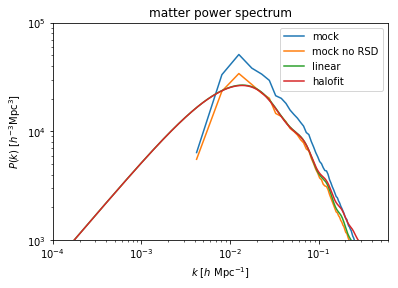

In [41]:
cat = BigFileCatalog('/global/cscratch1/sd/huikong/wtheta_cal/mock_corr/output/mocks2/mocks/mock0.bigfile', header='Header')

#this is a toy line of sight, it is not what is done when actually computing rsd
line_of_sight = [0,0,1]
cat['RSDPosition'] = cat['Position'] + cat['VelocityOffset'] * line_of_sight

mesh = cat.to_mesh(window='tsc', Nmesh=512, compensated=True, position='RSDPosition')
mesh2 = cat.to_mesh(window='tsc', Nmesh=512, compensated=True, position='Position')
# compute the power, specifying desired linear k-binning
r = FFTPower(mesh, mode='1d', dk=0.005, kmin=0.00001)
r2 = FFTPower(mesh2, mode='1d', dk=0.005, kmin=0.00001)
Pk = r.power
Pk2 = r2.power
print(Pk)


# print the shot noise subtracted P(k)
plt.loglog(Pk['k'], Pk['power'].real - Pk.attrs['shotnoise'],label='mock')
plt.loglog(Pk2['k'], Pk2['power'].real - Pk2.attrs['shotnoise'],label='mock no RSD')


logk = np.linspace(np.log(1e-4),np.log(10),1000)
k = np.exp(logk)
plt.plot(k,Plin(k),label='linear')
plt.plot(k,Plin2(k),label='halofit')


# format the axes
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.xlim(0.0001, 0.6)
plt.ylim(10**3,10**5)

plt.title('matter power spectrum')
plt.legend()

### FFT of different types of P(k)
Next I want to check how the 3d correlation function look like with these mocks\
First, fourier transform the 3 power spectrum above to see how they look like in 3d correlation function

Text(0.5,1,'kmin=1e-4')

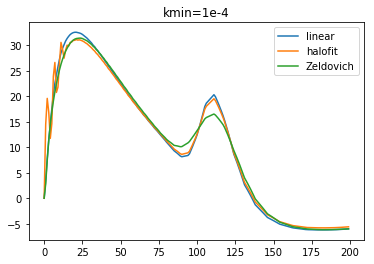

In [28]:
sys.path.append('/global/cscratch1/sd/huikong/wtheta_cal/software/')
def HankelTransform_corr(plin,bias=1,kmax=5,kmin=1e-4):
    N=200
    k_array = np.exp(np.array([ np.log(kmin)+i*(np.log(kmax)-np.log(kmin))/N for i in np.arange(0,200)]))
    pk = plin(k_array)
    q=1.5
    mu=0.5
    from BAOfit import fftlog_JB
    r,xi=fftlog_JB.HankelTransform(k_array,pk,q,mu,output_r=np.arange(0,200),output_r_power=-3)
    y=xi/np.pi**2*np.sqrt(np.pi/2)/2*bias**2
    return r,y

r0,y0=HankelTransform_corr(Plin)
r1,y1=HankelTransform_corr(Plin2)
rZ,yZ=HankelTransform_corr(Plin3)
plt.plot(r0,r0*r0*y0,label='linear')
plt.plot(r1,r1*r1*y1,label='halofit')
plt.plot(rZ,rZ*rZ*yZ,label='Zeldovich')
plt.legend()
plt.title("kmin=1e-4")

The halofit one has large wiggle on small scales, but it does not change much on large scales. \
Zelo'dovich one broadens the BAO bump, and has some effect on large scales

Since a simple mock lacks information on low k modes. \
I want to check how it looks like if we integrate the power spectrum starting from a higher k.\
This shows how these mock would mess up by losing these scales

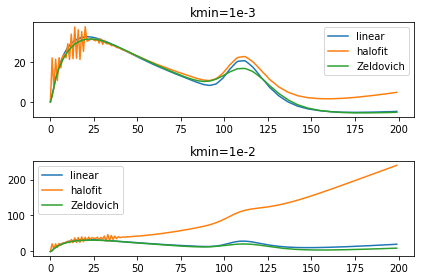

In [12]:
plt.subplot(2,1,1)
r0,y0=HankelTransform_corr(Plin,kmin=1e-3)
r1,y1=HankelTransform_corr(Plin2,kmin=1e-3)
rZ,yZ=HankelTransform_corr(Plin3,kmin=1e-3)
plt.plot(r0,r0*r0*y0,label='linear')
plt.plot(r1,r1*r1*y1,label='halofit')
plt.plot(rZ,rZ*rZ*yZ,label='Zeldovich')
plt.legend()
plt.title("kmin=1e-3")

plt.subplot(2,1,2)
r0,y0=HankelTransform_corr(Plin,kmin=1e-2)
r1,y1=HankelTransform_corr(Plin2,kmin=1e-2)
rZ,yZ=HankelTransform_corr(Plin3,kmin=1e-2)
plt.plot(r0,r0*r0*y0,label='linear')
plt.plot(r1,r1*r1*y1,label='halofit')
plt.plot(rZ,rZ*rZ*yZ,label='Zeldovich')
plt.legend()
plt.title("kmin=1e-2")

plt.tight_layout()

I think this would not happen on real data, since in real data, it should contain low k information even if they do not go to the scale of these low k mode. 

### 3d correlation function with lognormal mocks
next I comput 3d correlation function of the lognormal mocks. I have 100 mocks but I only computed 5 of them. Each mock has 10M sources, a compariative number 
as DESI LRG. It takes long cpu hours to compute, I might need more calculations to exclude chance flucuation....

In [32]:
topdir='/global/cscratch1/sd/huikong/wtheta_cal/mock_corr/output/mocks2/3dcorr_result/'
mocknames = dict({1:'3dcorrbox',2:'3dcorrbox2',3:'3dcorrbox3',4:'3dcorrbox4'})

X=[]
Y=[]
ERR=[]
for j in range(1,5):
    dat_list=[]
    for i in range(0,100):
        dat = np.loadtxt(topdir+'%s_%d.txt'%(mocknames[j],i)).transpose()
        dat_list.append(dat)
    
    x = dat_list[0][0]
    y = np.zeros_like(x)
    for i in range(100):
        y+=dat_list[i][1]
    y=y/100.
    
    std=np.zeros_like(x)
    for i in range(100):
        std+=(dat_list[i][1]-y)**2
    std=np.sqrt(std/100)
    std_ave = std/np.sqrt(100)
    X.append(x)
    Y.append(y)
    ERR.append(x*x*std_ave)

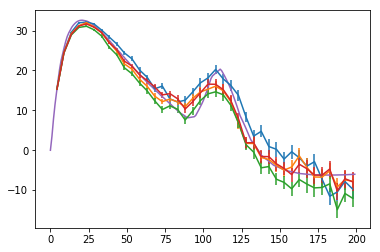

In [33]:
for i in range(0,4):
    plt.errorbar(X[i],X[i]*X[i]*Y[i],ERR[i])
r0,y0=HankelTransform_corr(Plin)
plt.plot(r0,r0*r0*y0,label='linear')

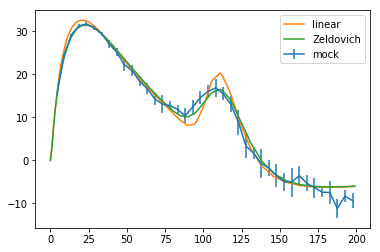

In [39]:
Y_mean = (Y[0]+Y[1]+Y[2]+Y[3])/4
std = np.sqrt(((Y[0]-Y_mean)**2+(Y[1]-Y_mean)**2+(Y[2]-Y_mean)**2+(Y[3]-Y_mean)**2)/4)
plt.errorbar(X[2],X[2]*X[2]*Y_mean,X[2]*X[2]*std,label='mock')
r0,y0=HankelTransform_corr(Plin)
rZ,yZ=HankelTransform_corr(Plin3)
plt.plot(r0,r0*r0*y0,label='linear')
plt.plot(rZ,rZ*rZ*yZ,label='Zeldovich')
plt.legend()

### covariance matrix test
In this section I compare the wtheta covariance matrix obtained by lognormal mock and the theory code called 'CosmoCov' made by Xiao. The mock need to have a high enough number density to avoid the covariance being dominated by possion noise. RSD in this mock is taken good care of. Also, this time the mock is cut to a thin shell of redshift z=0.3+/-0.015, so we can have uniform density distribution across the sky, making it easier to compare with the theory. Also it makes it possible to get w(theta) out of the mock

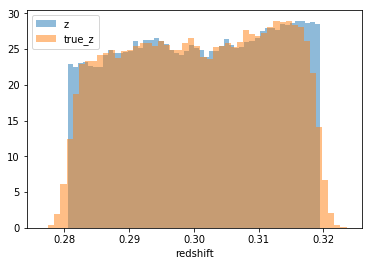

In [43]:
topdir = '/global/cscratch1/sd/huikong/wtheta_cal/mock_corr/output/mocks4/angcorr_data/'
dat1=fits.getdata(topdir+'rsd_angcorr1.fits')
plt.hist(dat1['z'],alpha=0.5,bins=50,label='z',density=True)
plt.hist(dat1['true_z'],alpha=0.5,bins=50,label='true_z',density=True)
plt.xlabel('redshift')
plt.legend()

Text(0,0.5,'$\\Delta ra$')

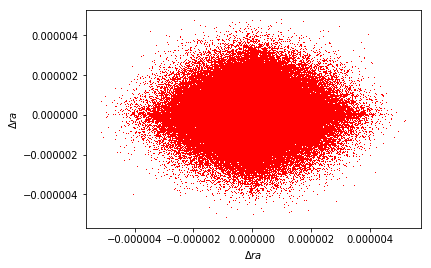

In [44]:
#valiating ra,dec does not get changed much with rsd, ideally they should be exactly the same
plt.plot(dat1['ra']-dat1['true_ra'],dat1['dec']-dat1['true_dec'],'r,')
plt.xlabel(r'$\Delta ra$')
plt.ylabel(r'$\Delta ra$')

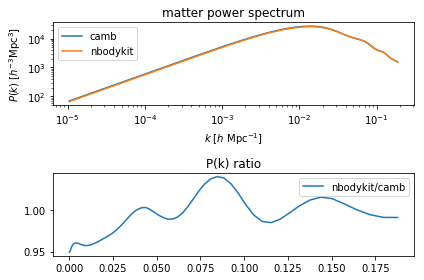

In [46]:
# pk from camb and nbodykit are slight different. I don't know why but probably not a big deal
# camb has 3 nonlinar settings: linear_pk, nonlinear_pk--same as halofit pk in nbodykit, nonlinear_lens--not sure what it is, it also has linear pk
plt.subplot(2,1,1)
cosmo = cosmology.cosmology.Cosmology(h=h,Omega0_b=omega_b,Omega0_cdm=omega_m-omega_b,n_s=ns)
cosmo2=cosmo.match(sigma8=sigma8)
Plin = cosmology.LinearPower(cosmo2, redshift, transfer='EisensteinHu')

pk2=np.loadtxt('/global/cscratch1/sd/huikong/wtheta_cal/mock_corr/nbody_kit/notebook/external_data/pk.txt').transpose()
plt.plot(pk2[0][:222],pk2[1][:222],label='camb')

k=pk2[0][:222]
mx=Plin(k).max()

plt.plot(k,Plin(k),label='nbodykit')
plt.legend()
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.title('matter power spectrum')

plt.subplot(2,1,2)
plt.plot(k,Plin(k)/pk2[1][:222],label='nbodykit/camb')
plt.legend()
plt.title('P(k) ratio')
plt.tight_layout()

#### rsd is making a big difference in wtheta

100
100


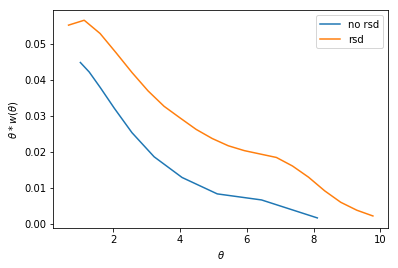

In [69]:

topdir = '/global/cscratch1/sd/huikong/wtheta_cal/mock_corr/output/mocks2/angcorr_result/'
#non rsd
import glob
fns = glob.glob(topdir+'angcorr_*')
length = len(fns)
print(length)
ang_corr=None
for fn in fns:
    ang_corr_i = np.loadtxt(fn).transpose()
    #print(fn)
    if ang_corr is None:
        ang_corr = ang_corr_i
    else:
        #print(fn)
        ang_corr+=ang_corr_i

ang_corr = ang_corr/length
#rsd
fns = glob.glob(topdir+'rsd_angcorr_*')
length = len(fns)
print(length)
rsd_ang_corr=None
for fn in fns:
    ang_corr_i = np.loadtxt(fn).transpose()
    #print(fn)
    if rsd_ang_corr is None:
        rsd_ang_corr = ang_corr_i
    else:
        #print(fn)
        rsd_ang_corr+=ang_corr_i

rsd_ang_corr = rsd_ang_corr/length

ang_corr_var=None
ang_corr_var2=None
length_ang = len(fns)
for fn in fns:
    ang_corr_i = np.loadtxt(fn).transpose()
    #print(fn)
    if ang_corr_var is None:
        ang_corr_var = (ang_corr_i[1]-rsd_ang_corr[1])**2
        ang_corr_var2 = ang_corr_i[2]
    else:
        ang_corr_var += (ang_corr_i[1]-rsd_ang_corr[1])**2
        ang_corr_var2 += ang_corr_i[2]

x=ang_corr[0]
ang_corr_var = np.sqrt(ang_corr_var/(length_ang-1))
ang_corr_var2 = np.sqrt(ang_corr_var2/length_ang)

plt.plot(ang_corr[0],ang_corr[0]*ang_corr[1],label='no rsd')
plt.plot(rsd_ang_corr[0],rsd_ang_corr[0]*rsd_ang_corr[1],label='rsd')
plt.ylabel(r'$\theta*w(\theta)$')
plt.xlabel(r'$\theta$')
plt.legend()

### angular correlation function from theory and mock
same mock as above, the non-gaus and gaus is indistinguishable in this plot

Text(0.5,1,'mock bias=1')

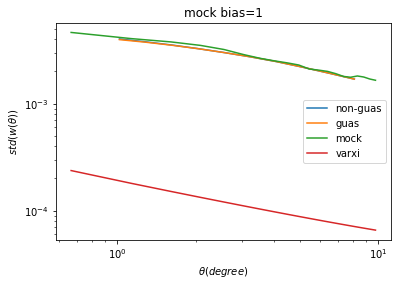

In [67]:
topdir='/global/cscratch1/sd/huikong/wtheta_cal/mock_corr/theory_corr/CosmoCov/covs/output/out_cov_mock_gaus/'
fn = topdir+'test_mock2_llll_cov_Ntheta10_Ntomo0_1'
cov = np.loadtxt(fn)
gaus_angle=[]
gaus_value=[]
for i in range(len(cov)):
    if cov[i][0]==cov[i][1]:
        gaus_angle.append(cov[i][2])
        gaus_value.append(cov[i][8])
        
topdir='/global/cscratch1/sd/huikong/wtheta_cal/mock_corr/theory_corr/CosmoCov/covs/output/out_cov_mock_non_gaus/'
fn = topdir+'test_mock2_llll_cov_Ntheta10_Ntomo0_1'
cov = np.loadtxt(fn)
non_gaus_angle=[]
non_gaus_value=[]
for i in range(len(cov)):
    if cov[i][0]==cov[i][1]:
        non_gaus_angle.append(cov[i][2])
        non_gaus_value.append(cov[i][8]+cov[i][9])
        
plt.plot(np.array(non_gaus_angle)*180/np.pi,np.sqrt(np.array(non_gaus_value)),label='non-guas')
plt.plot(np.array(gaus_angle)*180/np.pi,np.sqrt(np.array(gaus_value)),label='guas')
plt.plot(rsd_ang_corr[0],ang_corr_var,label='mock') 
plt.plot(rsd_ang_corr[0],ang_corr_var2,label='varxi')

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel(r'$\theta (degree)$')
plt.ylabel(r'$std(w(\theta))$')
plt.legend()
plt.title('mock bias=1')

I also made another set of mock, everything are the same but this time bias=2.0, the covariance matrix match seems a bit worse, I can't remember whether this two mock have the same density now....

100


Text(0.5,1,'mock bias=2')

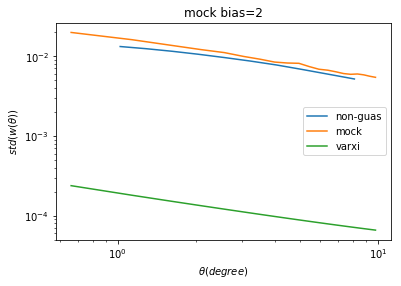

In [59]:
topdir = '/global/cscratch1/sd/huikong/wtheta_cal/mock_corr/output/mocks4/angcorr_result/'
#rsd
fns = glob.glob(topdir+'rsd_angcorr_*')
length = len(fns)
print(length)
rsd_ang_corr=None
for fn in fns:
    ang_corr_i = np.loadtxt(fn).transpose()
    #print(fn)
    if rsd_ang_corr is None:
        rsd_ang_corr = ang_corr_i
    else:
        #print(fn)
        rsd_ang_corr+=ang_corr_i

rsd_ang_corr = rsd_ang_corr/length

ang_corr_var=None
ang_corr_var2=None
length_ang = len(fns)
for fn in fns:
    ang_corr_i = np.loadtxt(fn).transpose()
    #print(fn)
    if ang_corr_var is None:
        ang_corr_var = (ang_corr_i[1]-rsd_ang_corr[1])**2
        ang_corr_var2 = ang_corr_i[2]
    else:
        ang_corr_var += (ang_corr_i[1]-rsd_ang_corr[1])**2
        ang_corr_var2 += ang_corr_i[2]

x=rsd_ang_corr[0]
ang_corr_var = np.sqrt(ang_corr_var/(length_ang-1))
ang_corr_var2 = np.sqrt(ang_corr_var2/length_ang)

topdir='/global/cscratch1/sd/huikong/wtheta_cal/mock_corr/theory_corr/CosmoCov/covs/output/mock4/'
fn = topdir+'test_mock2_llll_cov_Ntheta10_Ntomo0_1'
cov = np.loadtxt(fn)
gaus_angle=[]
gaus_value=[]
for i in range(len(cov)):
    if cov[i][0]==cov[i][1]:
        gaus_angle.append(cov[i][2])
        gaus_value.append(cov[i][8])
        
topdir='/global/cscratch1/sd/huikong/wtheta_cal/mock_corr/theory_corr/CosmoCov/covs/output/mock4/'
fn = topdir+'test_mock2_llll_cov_Ntheta10_Ntomo0_1'
cov = np.loadtxt(fn)
non_gaus_angle=[]
non_gaus_value=[]
for i in range(len(cov)):
    if cov[i][0]==cov[i][1]:
        non_gaus_angle.append(cov[i][2])
        non_gaus_value.append(cov[i][8]+cov[i][9])
        

plt.plot(np.array(non_gaus_angle)*180/np.pi,np.sqrt(np.array(non_gaus_value)),label='non-guas')
plt.plot(rsd_ang_corr[0],ang_corr_var,label='mock') 
plt.plot(rsd_ang_corr[0],ang_corr_var2,label='varxi')

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel(r'$\theta (degree)$')
plt.ylabel(r'$std(w(\theta))$')
plt.legend()
plt.title('mock bias=2')

### wtheta comparision
In this section I'm using the previous 100 mocks cut to z~0.3 shell to compute angular wtheta from mock. For the theory code, I'm using anna's code that's built in with cosmosis. The cosmosis are either linear pk or rsd included

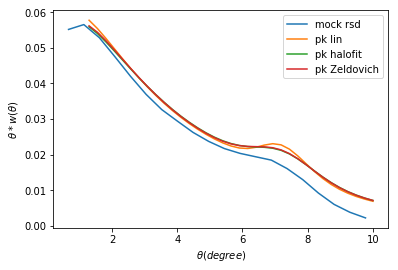

In [113]:
fn = '/global/cscratch1/sd/huikong/wtheta_cal/mock_corr/nbody_kit/notebook/external_data/angcorr_theory.txt' 
#cosmosis
topdir = '/global/cscratch1/sd/huikong/fnl_analysis/theory_desi_MOCK/lss_autocorrelation/'
topdir2='/global/cscratch1/sd/huikong/fnl_analysis/theory_desi_MOCKlin/lss_autocorrelation/'


theta = np.loadtxt(topdir+'theta_deg.txt')
wtheta = np.loadtxt(topdir+'bin_1_1.txt')

theta2 = np.loadtxt(topdir2+'theta_deg.txt')
wtheta2 = np.loadtxt(topdir2+'bin_1_1.txt')

import numpy as np
dat = np.loadtxt(fn).transpose()
plt.plot(rsd_ang_corr[0],rsd_ang_corr[0]*rsd_ang_corr[1],label='mock rsd')
#plt.plot(dat[0][5:],dat[0][5:]*dat[1][5:],label='theory rsd')
#plt.plot(theta[5:],theta[5:]*wtheta[5:],label='theory rsd cosmosis')
#plt.plot(theta2[5:],theta2[5:]*wtheta2[5:],label='theory rsd cosmosis lin')
plt.ylabel(r'$\theta*w(\theta)$') 
plt.xlabel(r'$\theta (degree)$')

topdir3 = '/global/cscratch1/sd/huikong/fnl_analysis/wtheta_standalone/output/'
fn2 = topdir3+'wtheta_4bins_nonlinear_bin_2.txt'
fn3 = topdir3+'wtheta_4bins_nonlinear_bin_3.txt'
fn4 = topdir3+'wtheta_4bins_nonlinear_bin_4.txt'

dat2 = np.loadtxt(fn2).transpose()
theta2=dat2[0]

dat3 = np.loadtxt(fn3).transpose()
theta3=dat3[0]

dat4 = np.loadtxt(fn4).transpose()
theta4=dat4[0]

plt.plot(theta2[5:],theta2[5:]*dat2[1][5:],label = 'pk lin')
plt.plot(theta3[5:],theta3[5:]*dat3[1][5:],label = 'pk halofit')
plt.plot(theta4[5:],theta4[5:]*dat4[1][5:],label = 'pk Zeldovich')
plt.xlabel(r'$\theta (degree)$')
plt.ylabel(r'$\theta*w(\theta)$')
plt.legend()

### fnl--bias contour plot
In this test, number density is the same as desi LRG, I'm assuming input 'real data' wtheta is exactly the same as the theory curve of fnl=0

Text(0.5,0,'fnl')

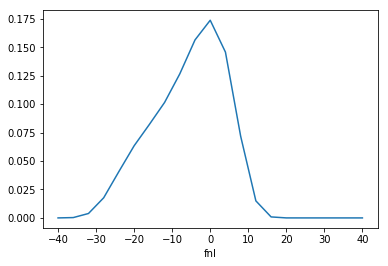

In [76]:
data = np.loadtxt('/global/cscratch1/sd/huikong/wtheta_cal/cosmosis/theory_desi_DESI_IRG/gridtest.txt').transpose()
plt.plot(data[0],np.exp(-0.5*data[1])/sum(np.exp(-0.5*data[1])))
plt.xlabel('fnl')

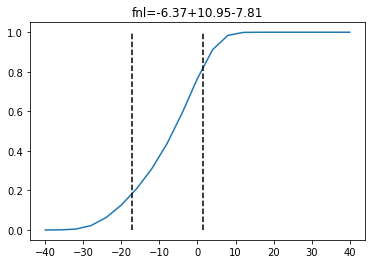

In [94]:
#cdf plot
y=[]
sums=0
for i in range(len(data[0])):
    xi=np.exp(-0.5*data[1])[i]/sum(np.exp(-0.5*data[1]))
    sums+=xi
    y.append(sums)
y = np.array(y)
from scipy.interpolate import interp1d
x=data[0]
f = interp1d(y, x)
x_left = float(f(0.5-0.638/2.))
x_middle = float(f(0.5))
x_right = float(f(0.5+0.638/2.))
plt.title('fnl=%.2f+%.2f-%.2f'%(x_middle,x_middle-x_left,x_right-x_middle))
p=plt.plot(data[0],y)
p=plt.plot(x_left*np.ones(len(x)),y,'k--')
p=plt.plot(x_right*np.ones(len(x)),y,'k--')